In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model


In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-02-29 14:03:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.197.208, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.197.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  11.2MB/s    in 8.5s    

2020-02-29 14:03:28 (9.87 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

In [5]:
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer shape is',last_layer.output_shape )
last_output = last_layer.output

last layer shape is (None, 7, 7, 768)


Define a callback class that stops training once after accuracy reaches 99.9%



In [30]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs = {}):
        if(logs.get('acc') > 0.999):
            print("\nReached over 99.9% accuracy... so cancelling training")
            self.model.stop_training = True

In [31]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model( pre_trained_model.input, x)
model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics = ['acc'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [9]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  

--2020-02-29 14:03:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.197.208, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.197.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  10.3MB/s    in 13s     

2020-02-29 14:03:46 (10.8 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-02-29 14:03:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.197.208, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.197.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [applicat

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [32]:
train_horses_dir = '/tmp/training/horses'
train_humans_dir = '/tmp/training/humans'
validation_horses_dir = '/tmp/validation/horses'
validation_humans_dir = '/tmp/validation/humans'

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [33]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.)


In [34]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode='binary', target_size = (150,150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode='binary', target_size = (150,150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [35]:
callbacks = [myCallback()]
history = model.fit_generator( train_generator, validation_data = validation_generator, steps_per_epoch = 49, epochs = 40, validation_steps = 10, verbose=1, callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 49 steps, validate for 10 steps
Epoch 1/40
49/49 [==============================] - 7s 147ms/step - loss: 0.3716 - acc: 0.8612 - val_loss: 0.0166 - val_acc: 0.9900
Epoch 2/40
49/49 [==============================] - 5s 93ms/step - loss: 0.1750 - acc: 0.9261 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 3/40
49/49 [==============================] - 5s 93ms/step - loss: 0.1351 - acc: 0.9507 - val_loss: 0.0128 - val_acc: 0.9900
Epoch 4/40
49/49 [==============================] - 5s 93ms/step - loss: 0.1038 - acc: 0.9589 - val_loss: 0.0542 - val_acc: 0.9900
Epoch 5/40
49/49 [==============================] - 5s 93ms/step - loss: 0.0986 - acc: 0.9612 - val_loss: 1.0659e-04 - val_acc: 1.0000
Epoch 6/40
49/49 [==============================] - 5s 92ms/step - loss: 0.1084 - acc: 0.9630 - val_loss: 3.9882e-05 - val_acc: 1.0000
Epoch 7/40
49/49 [==============================] - 5s 93ms/step - loss: 0.0969 - acc: 0.9592 - val_loss: 0.2062 

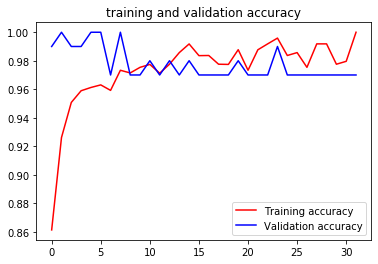

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title("training and validation accuracy")
plt.legend(loc=0)
plt.figure()

plt.show()